In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from func.assets import *
from func.ballistic_tables import load_ballistic_tables
from func.classes import ProjectileSixDof
from func.drag import init_drag_tables, available_drag_models
from func.solver import SolverConfig, solve_scenario_external_ballistics_only

In [2]:
def interpolate_trajectory(
    data_file: str,
    sample_by: str = 'distance',
    sample_number: int = 100,
    stop: float = None
) -> pd.DataFrame:
  """
  Интерполирует траекторные данные из CSV и возвращает равномерно распределённые точки.

  Параметры:
    data_file (str): путь к CSV-файлу с колонками: x_m, z_m, speed_mps, t_s
    sample_by (str): по какой переменной делать равномерную дискретизацию.
                     Возможные значения: 'distance', 'speed', 'time', 'drop'
    sample_number (int): количество точек в выходном наборе
    stop (float/int): конечное значение для интерполяции.
                      Если положительное — интерполируется от 0 до stop.
                      Если отрицательное — от stop до 0.

  Возвращает:
    pd.DataFrame с колонками: x_m, z_m, speed_mps, t_s
  """
  # Загрузка данных
  df = pd.read_csv(data_file)

  # Определение входной и выходных переменных
  mapping = {
    'distance': ('x_m', ['z_m', 'speed_mps', 't_s']),
    'speed': ('speed_mps', ['x_m', 'z_m', 't_s']),
    'time': ('t_s', ['x_m', 'z_m', 'speed_mps']),
    'drop': ('z_m', ['x_m', 'speed_mps', 't_s'])
  }

  if sample_by not in mapping:
    raise ValueError("sample_by must be one of: 'distance', 'speed', 'time', 'drop'")

  x_col, y_cols = mapping[sample_by]

  # Определение диапазона интерполяции
  x_min = df[x_col].min()
  x_max = df[x_col].max()

  if stop is None:
    stop = x_max

  if stop >= 0:
    start_val = 0.0
    end_val = float(stop)
  else:
    start_val = float(stop)
    end_val = 0.0

  # Проверка, что диапазон внутри или частично перекрывается данными
  if start_val < x_min or end_val > x_max:
    raise ValueError(f"Requested range [{start_val}, {end_val}] exceeds data bounds [{x_min}, {x_max}] for column '{x_col}'")

  # Создание равномерной сетки
  x_new = np.linspace(start_val, end_val, sample_number)

  # Интерполяция каждой выходной колонки
  interp_data = {x_col: x_new}
  for col in y_cols:
    interp_func = lambda x, xp=df[x_col], fp=df[col]: np.interp(x, xp, fp)
    interp_data[col] = interp_func(x_new)

  # Сборка результата в правильном порядке
  result_df = pd.DataFrame({
    'x_m': interp_data['x_m'] if 'x_m' in interp_data else np.interp(x_new, df[x_col], df['x_m']),
    'z_m': interp_data['z_m'] if 'z_m' in interp_data else np.interp(x_new, df[x_col], df['z_m']),
    'speed_mps': interp_data['speed_mps'] if 'speed_mps' in interp_data else np.interp(x_new, df[x_col], df['speed_mps']),
    't_s': interp_data['t_s'] if 't_s' in interp_data else np.interp(x_new, df[x_col], df['t_s'])
  })

  return result_df

In [3]:
def fmt_energy_j(e_j: float) -> str:
  e = float(e_j)
  if e >= 1e6:
    return f"{e / 1e6:.3f} MJ"
  if e >= 1e3:
    return f"{e / 1e3:.3f} kJ"
  return f"{e:.3f} J"


def lerp(a: float, b: float, t: float) -> float:
  return a + (b - a) * t


def lerp_color(c0: tuple[float, float, float],
               c1: tuple[float, float, float],
               t: float) -> tuple[float, float, float]:
  t = float(np.clip(t, 0.0, 1.0))
  return (
    lerp(c0[0], c1[0], t),
    lerp(c0[1], c1[1], t),
    lerp(c0[2], c1[2], t),
  )


def mach_to_color(mach: float,
                  *,
                  m_sub_max: float = 1.0,
                  m_sup_max: float = 3.0) -> tuple[float, float, float]:
  # Дозвук: синий -> фиолетовый
  sub0 = mcolors.to_rgb('#2a6fdb')  # blue
  sub1 = mcolors.to_rgb('#7a2adb')  # violet

  # Сверхзвук: оранжевый -> красный
  sup0 = mcolors.to_rgb('#ff8c1a')  # orange
  sup1 = mcolors.to_rgb('#e0002a')  # red

  m = float(mach)
  if m < 1.0:
    t = m / max(m_sub_max, 1e-9)
    return lerp_color(sub0, sub1, t)
  t = (m - 1.0) / max(m_sup_max - 1.0, 1e-9)
  return lerp_color(sup0, sup1, t)

In [4]:
paths = AssetPaths(Path('.'))
scenario = load_scenario(paths, 'demo-1.yaml')
weapon = load_weapon(paths, scenario.weapon.id)
ammo = load_ammo(paths, scenario.ammo.id)
medium = load_medium(paths, scenario.environment.medium)

In [5]:
tables = load_ballistic_tables('model/ballistic.yaml')
init_drag_tables(tables)

available_drag_models()

['G1', 'G2', 'G7', 'Rod', 'Sphere']

In [6]:
six = ProjectileSixDof.from_dict(load_yaml(Path('sample/m855_6dof.yaml')))

In [13]:
gravity = 9.79342  # Houston, TX
solver_config = SolverConfig(
  dt_s=0.01,
  six_dof_force_scale=0.2,
  six_dof_aoa_limit_rad=0.02
)

In [14]:
res = solve_scenario_external_ballistics_only(
  scenario=scenario,
  weapon=weapon,
  ammo=ammo,
  medium=medium,
  gravity_mps2=gravity,
  config=solver_config,
  six_dof=six
)

In [35]:
sample = interpolate_trajectory(
  data_file='sample/m855_62gr.csv',
  sample_by='time',
  sample_number=80+1,
  stop=0.8
)
sample

,x_m,z_m,speed_mps,t_s
0,0.000000,0.000000,910.000000,0.00
1,9.090909,-0.003091,900.909091,0.01
2,18.181818,-0.006182,891.818182,0.02
3,27.272727,-0.009273,882.727273,0.03
4,36.363636,-0.012364,873.636364,0.04
...,...,...,...,...
76,533.862434,-2.332407,479.682540,0.76
77,539.153439,-2.389815,476.507937,0.77
78,544.444444,-2.447222,473.333333,0.78
79,549.735450,-2.504630,470.158730,0.79


In [16]:
display(f"Stop reason: {res.meta.stop_reason}")
res.trajectory

'Stop reason: max_distance'

,t_s,x_m,y_m,z_m,drop_m,vx_mps,vy_mps,vz_mps,speed_mps,rel_speed_mps,mach,energy_j,angle_x,angle_y,angle_z,angvel_x,angvel_y,angvel_z,aoa
0,0.00,0.000000,0.000000,0.000000,-0.000000,910.000000,0.000000,0.000000,910.000000,905.500000,2.637942,1656.200000,0.000000e+00,0.000000,0.000000,-32158.035037,-0.000000,-0.000000,0.000000
1,0.01,9.044657,0.000000,-0.000491,0.000491,898.976339,0.010280,-0.098201,898.976344,894.476344,2.605827,1616.316934,-3.215807e+02,0.026060,-0.002699,-32158.140913,85.025819,-735.095259,0.026309
2,0.02,17.980411,-0.000358,-0.001990,0.001990,888.217868,-0.036188,-0.151032,888.217881,883.717881,2.574485,1577.862010,-8.706267e+03,-1.520715,-0.595518,-7340.833251,2857.682042,199844.804337,1.529169
3,0.03,26.809866,-0.001707,-0.003450,0.003450,877.715070,-0.284118,-0.196555,877.715138,873.215138,2.543888,1540.767727,-8.673777e+09,0.040237,-1.232356,-63349.300244,189535.568498,-7945.717894,1.232325
4,0.04,35.535535,-0.003509,-0.005324,0.005324,867.459114,-0.125509,-0.127440,867.459132,862.959132,2.514010,1504.970692,-1.897958e+10,0.023269,0.339328,-188408.567055,-66637.800566,-7849.547497,0.340249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2.41,992.426261,0.456953,-17.053814,17.053814,230.444306,0.337028,-14.458542,230.897686,226.406697,0.659578,106.627483,-2.613588e+12,-0.689596,0.741796,-113986.863091,-106701.571861,124987.077753,0.915947
242,2.42,994.728185,0.460305,-17.198744,17.198744,229.940711,0.336609,-14.530956,230.399637,225.908778,0.658127,106.167985,-2.624637e+12,-0.730023,-1.659241,15898.771709,147019.074238,134657.420398,1.594692
243,2.43,997.025091,0.463651,-17.344333,17.344333,229.441046,0.329338,-14.586672,229.904487,225.413739,0.656685,105.712146,-2.635684e+12,0.393254,-0.468787,-162901.706054,85205.452346,-78759.539456,0.648676
244,2.44,999.317010,0.466991,-17.490547,17.490547,228.943499,0.338729,-14.652846,229.412175,224.921552,0.655251,105.259892,-2.646700e+12,-0.699724,0.745301,-112661.806118,-106243.971463,126568.305551,0.922609


/var/folders/pq/h_ny4csn6sgbvw7g3smwwd4m0000gn/T/ipykernel_97906/3607113499.py:122: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


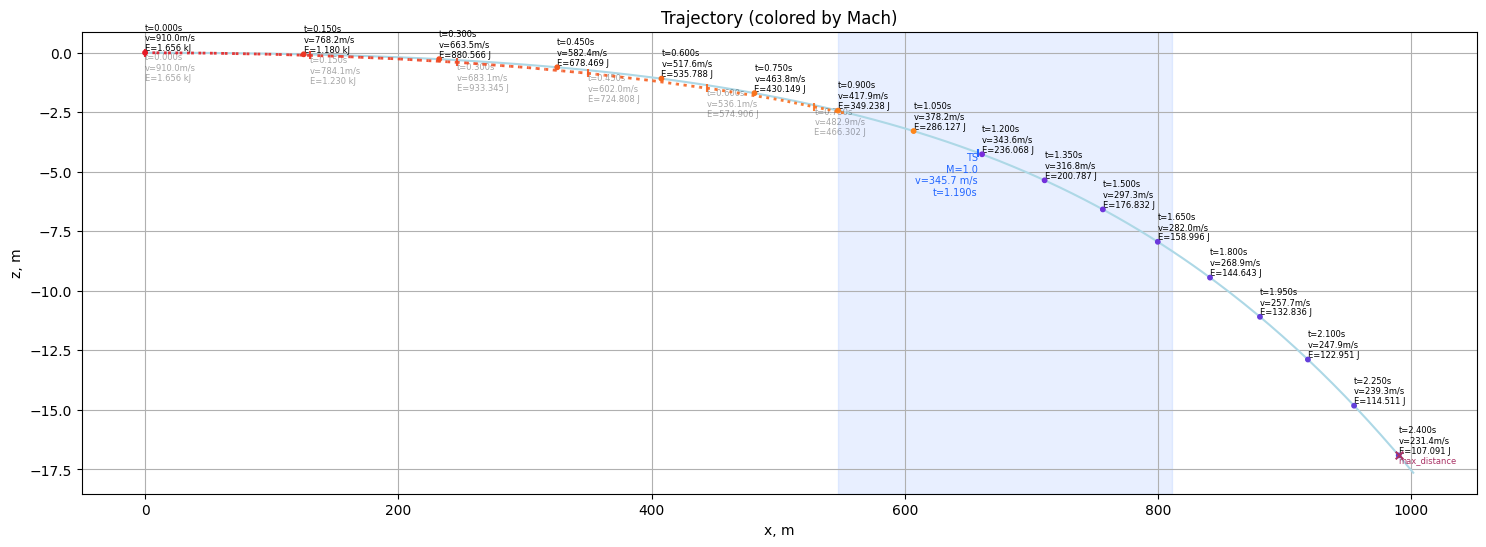

In [45]:
fig, ax = plt.subplots(figsize=(18, 6))

x = res.trajectory['x_m']
y = res.trajectory['z_m']
ax.plot(
  x, y,
  c='lightblue'
)
step = 15
df = res.trajectory.iloc[::step].reset_index(drop=True)

mx = df['x_m'].to_numpy(dtype=np.float64)
mz = df['z_m'].to_numpy(dtype=np.float64)
mach = df['mach'].to_numpy(dtype=np.float64)

colors = [mach_to_color(m) for m in mach]

ax.scatter(mx, mz, s=10, c=colors, zorder=10)

# Подписи
for i in range(len(df)):
  t_s = float(df.loc[i, 't_s'])
  v = float(df.loc[i, 'speed_mps'])
  e = float(df.loc[i, 'energy_j'])
  label = f"t={t_s:.3f}s\nv={v:.1f}m/s\nE={fmt_energy_j(e)}"
  ax.text(
    mx[i], mz[i],
    label,
    fontsize=6,
    ha='left',
    va='bottom',
  )

mach_full = res.trajectory['mach'].to_numpy()

ts_idx = None
for i in range(1, len(mach_full)):
  if mach_full[i - 1] >= 1.0 and mach_full[i] < 1.0:
    ts_idx = i
    break

if ts_idx is not None:
  ts_x = res.trajectory.loc[ts_idx, 'x_m']
  ts_z = res.trajectory.loc[ts_idx, 'z_m']
  ts_t = res.trajectory.loc[ts_idx, 't_s']
  ts_v = res.trajectory.loc[ts_idx, 'speed_mps']

  ax.scatter(
    [ts_x], [ts_z],
    s=30,
    c='#26f',
    marker='|',
    zorder=20,
  )
  ax.text(
    ts_x, ts_z,
    f"TS\nM=1.0\nv={ts_v:.1f} m/s\nt={ts_t:.3f}s",
    fontsize=7,
    ha='right',
    va='top',
    color='#26f',
  )
ax.axvspan(
  res.trajectory.loc[mach_full > 1.2, 'x_m'].max(),
  res.trajectory.loc[mach_full < 0.8, 'x_m'].min(),
  color='#26f',
  alpha=0.1,
  zorder=0,
)

last_x, last_y = df.iloc[-1][['x_m', 'z_m']]
ax.scatter(
  [last_x], [last_y],
  s=30,
  c='#a36',
  marker='x',
  zorder=20
)
ax.text(
  last_x, last_y,
  res.meta.stop_reason,
  fontsize=6,
  c='#a36',
  ha='left',
  va='top'
)

# --- эталон: цветная пунктирная линия + редкие точки + подписи ---
speed_of_sound = float(getattr(medium, 'speed_of_sound_m_s', 343.26))
m_proj_kg = float(ammo.projectile.mass_kg)

sample = sample.copy()
sample['mach'] = sample['speed_mps'] / max(speed_of_sound, 1e-9)
sample['energy_j'] = 0.5 * m_proj_kg * sample['speed_mps'] ** 2

sx = sample['x_m'].to_numpy(dtype=np.float64)
sz = sample['z_m'].to_numpy(dtype=np.float64)
smach = sample['mach'].to_numpy(dtype=np.float64)

# --- 1) Пунктирная линия эталона (по всем точкам) ---
for i in range(len(sample) - 1):
  m_seg = 0.5 * (smach[i] + smach[i + 1])
  ax.plot(
    [sx[i], sx[i + 1]],
    [sz[i], sz[i + 1]],
    c=mach_to_color(float(m_seg)),
    ls=':',
    lw=2,
    alpha=0.9,
    zorder=5,
  )

# --- 2) Редкие точки эталона ---
sample_step = 15  # <-- ВОТ ОН, общий шаг для точек и подписей

sx_s = sx[::sample_step]
sz_s = sz[::sample_step]
smach_s = smach[::sample_step]

s_colors = [mach_to_color(float(m)) for m in smach_s]

ax.scatter(
  sx_s, sz_s,
  s=32,
  c=s_colors,
  marker='|',
  edgecolors='none',
  alpha=0.9,
  zorder=6,
)

# --- 3) Подписи эталона (те же точки) ---
for i in range(0, len(sample), sample_step):
  t_s = float(sample.loc[i, 't_s'])
  v = float(sample.loc[i, 'speed_mps'])
  e = float(sample.loc[i, 'energy_j'])

  label = f"t={t_s:.3f}s\nv={v:.1f}m/s\nE={fmt_energy_j(e)}"

  ax.text(
    sample.loc[i, 'x_m'],
    sample.loc[i, 'z_m'],
    label,
    fontsize=6,
    ha='left',
    va='top',
    color='black',
    alpha=0.35,
    zorder=4,
  )

ax.set_xlabel('x, m')
ax.set_ylabel('z, m')
ax.set_title('Trajectory (colored by Mach)')
ax.grid(True)
# ax.set_aspect('equal', adjustable='box')

In [12]:
res.trajectory[['x_m', 'z_m', 'speed_mps', 't_s']][::10].to_csv('./output/m855_demo-2.csv', float_format='%.3f', index=False)